# iUROP Mask R-CNN Benchmarking
This notebook is part of the effort to benchmark different contemporary object detection algorithms with respect to traffic analysis.

Benchmarking points:

- Detection Time (Computational Cost)
- Vehicle Count
- Average Confidence
## Import Libs & other dependencies

In [33]:
!git clone https://github.com/tensorflow/tpu/

fatal: destination path 'tpu' already exists and is not an empty directory.


In [34]:
from IPython import display
from PIL import Image
import numpy as np
#import tensorflow as tf
import tensorflow.compat.v1 as tf
from tensorflow.python.lib.io import file_io
import sys
sys.path.insert(0, 'tpu/models/official')
sys.path.insert(0, 'tpu/models/official/mask_rcnn')
import coco_metric
from mask_rcnn.object_detection import visualization_utils
from datetime import datetime
     

In [35]:
ID_MAPPING = {
    1: 'person',
    2: 'bicycle',
    3: 'car',
    4: 'motorcycle',
    5: 'airplane',
    6: 'bus',
    7: 'train',
    8: 'truck',
    9: 'boat',
    10: 'traffic light',
    11: 'fire hydrant',
    13: 'stop sign',
    14: 'parking meter',
    15: 'bench',
    16: 'bird',
    17: 'cat',
    18: 'dog',
    19: 'horse',
    20: 'sheep',
    21: 'cow',
    22: 'elephant',
    23: 'bear',
    24: 'zebra',
    25: 'giraffe',
    27: 'backpack',
    28: 'umbrella',
    31: 'handbag',
    32: 'tie',
    33: 'suitcase',
    34: 'frisbee',
    35: 'skis',
    36: 'snowboard',
    37: 'sports ball',
    38: 'kite',
    39: 'baseball bat',
    40: 'baseball glove',
    41: 'skateboard',
    42: 'surfboard',
    43: 'tennis racket',
    44: 'bottle',
    46: 'wine glass',
    47: 'cup',
    48: 'fork',
    49: 'knife',
    50: 'spoon',
    51: 'bowl',
    52: 'banana',
    53: 'apple',
    54: 'sandwich',
    55: 'orange',
    56: 'broccoli',
    57: 'carrot',
    58: 'hot dog',
    59: 'pizza',
    60: 'donut',
    61: 'cake',
    62: 'chair',
    63: 'couch',
    64: 'potted plant',
    65: 'bed',
    67: 'dining table',
    70: 'toilet',
    72: 'tv',
    73: 'laptop',
    74: 'mouse',
    75: 'remote',
    76: 'keyboard',
    77: 'cell phone',
    78: 'microwave',
    79: 'oven',
    80: 'toaster',
    81: 'sink',
    82: 'refrigerator',
    84: 'book',
    85: 'clock',
    86: 'vase',
    87: 'scissors',
    88: 'teddy bear',
    89: 'hair drier',
    90: 'toothbrush',
}
category_index = {k: {'id': k, 'name': ID_MAPPING[k]} for k in ID_MAPPING}

### Load Image

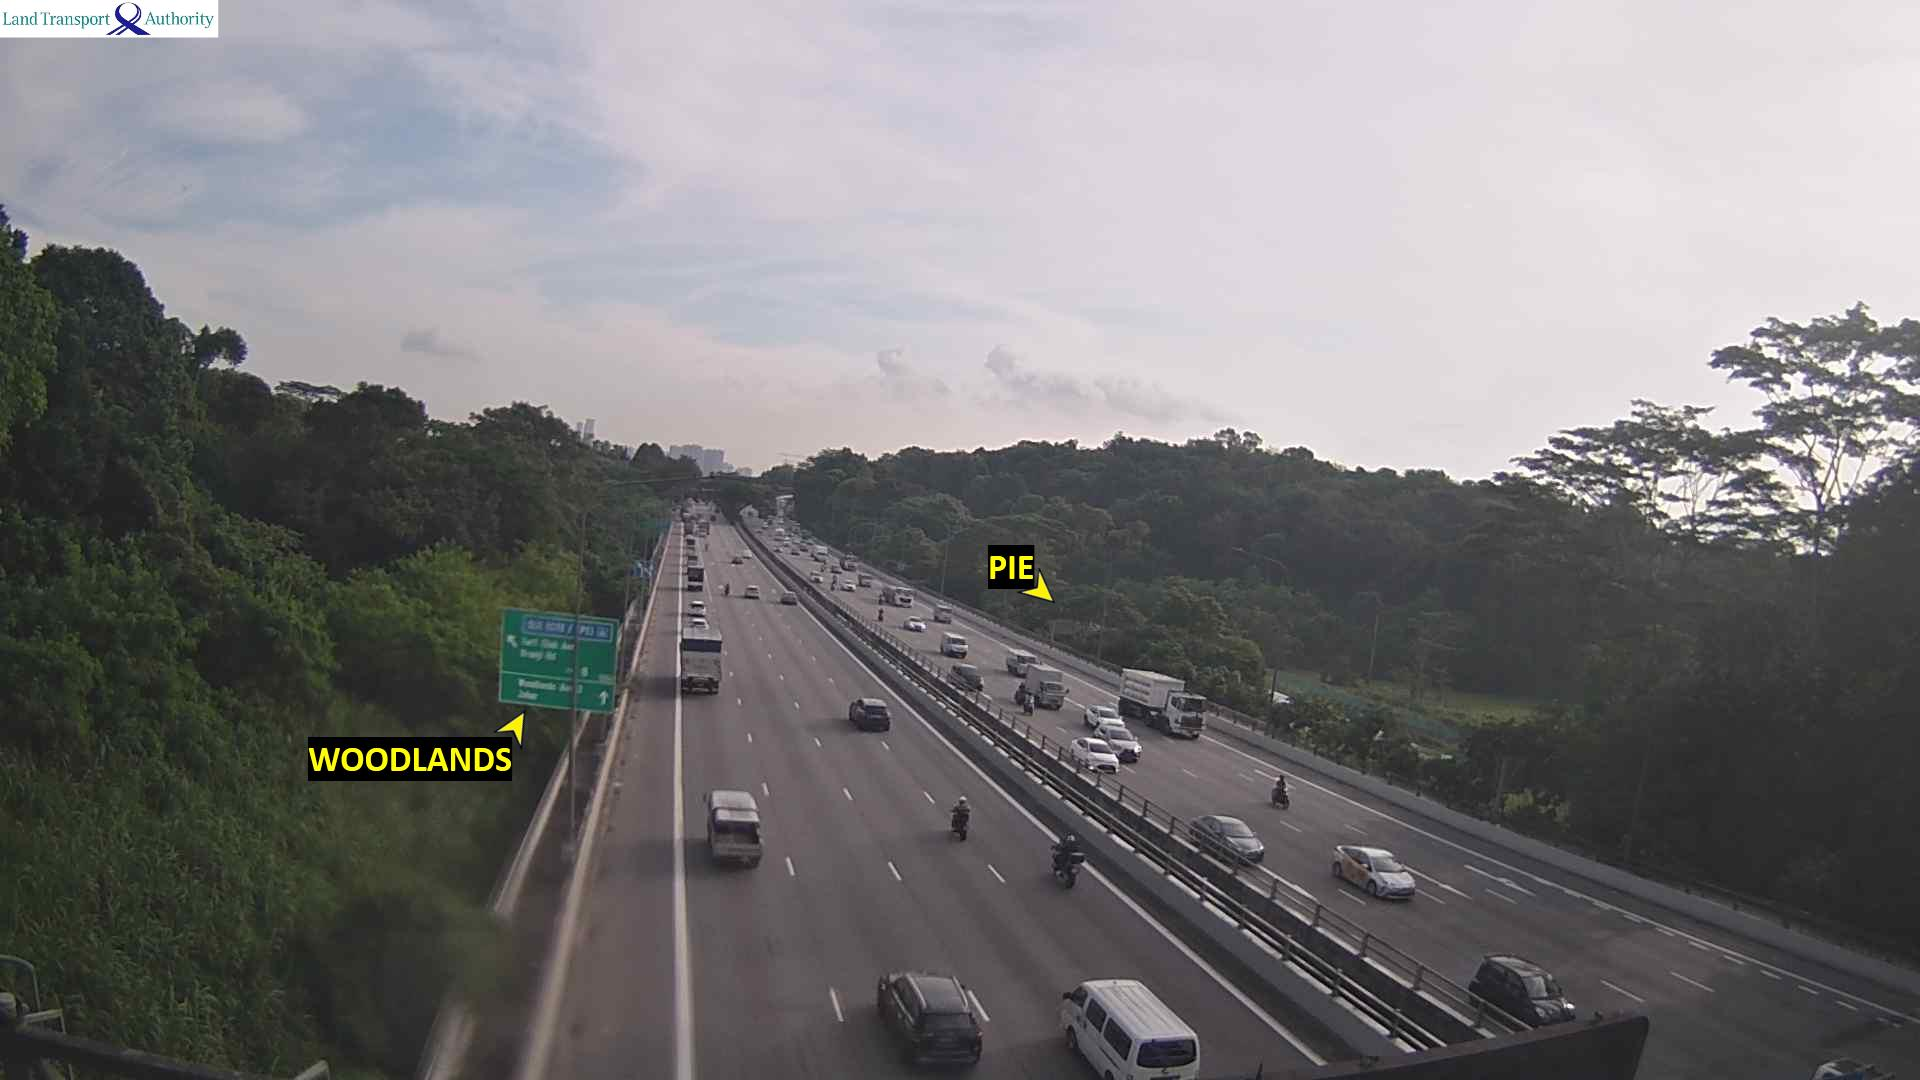

In [36]:
image_path = 'c6431e1d-fe35-4b97-a2e3-60e47e7ba921.jpg'
with open(image_path, 'rb') as f:
  np_image_string = np.array([f.read()])

image = Image.open(image_path)
width, height = image.size
np_image = np.array(image.getdata()).reshape(height, width, 3).astype(np.uint8)

display.display(display.Image(image_path, width=1024))

### Create tensorflow session

In [37]:
session = tf.Session(graph=tf.Graph())

In [38]:
import gcsfs
import shutil

gcs_path = 'gs://cloud-tpu-checkpoints/mask-rcnn/1555659850'
local_path = '/tmp/mask-rcnn'

fs = gcsfs.GCSFileSystem()
fs.get(gcs_path, local_path, recursive=True)


[None, None, None, None, None, None, None]

In [39]:
# Ensure TensorFlow handles memory growth properly
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Load the saved model from local path
loaded_model = tf.saved_model.loader.load(session, ['serve'],local_path)

print("Model loaded successfully")


INFO:tensorflow:Restoring parameters from /tmp/mask-rcnn\variables\variables
Model loaded successfully


In [40]:
start_time = datetime.now()
num_detections, detection_boxes, detection_classes, detection_scores, detection_masks, image_info = session.run(
    ['NumDetections:0', 'DetectionBoxes:0', 'DetectionClasses:0', 'DetectionScores:0', 'DetectionMasks:0', 'ImageInfo:0'],
    feed_dict={'Placeholder:0': np_image_string})
detection_time = (datetime.now() - start_time).microseconds * 0.001 # Miliseconds

num_detections = np.squeeze(num_detections.astype(np.int32), axis=(0,))
detection_boxes = np.squeeze(detection_boxes * image_info[0, 2], axis=(0,))[0:num_detections]
detection_scores = np.squeeze(detection_scores, axis=(0,))[0:num_detections]
detection_classes = np.squeeze(detection_classes.astype(np.int32), axis=(0,))[0:num_detections]
instance_masks = np.squeeze(detection_masks, axis=(0,))[0:num_detections]
ymin, xmin, ymax, xmax = np.split(detection_boxes, 4, axis=-1)
processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)
segmentations = coco_metric.generate_segmentation_from_masks(instance_masks, processed_boxes, height, width)

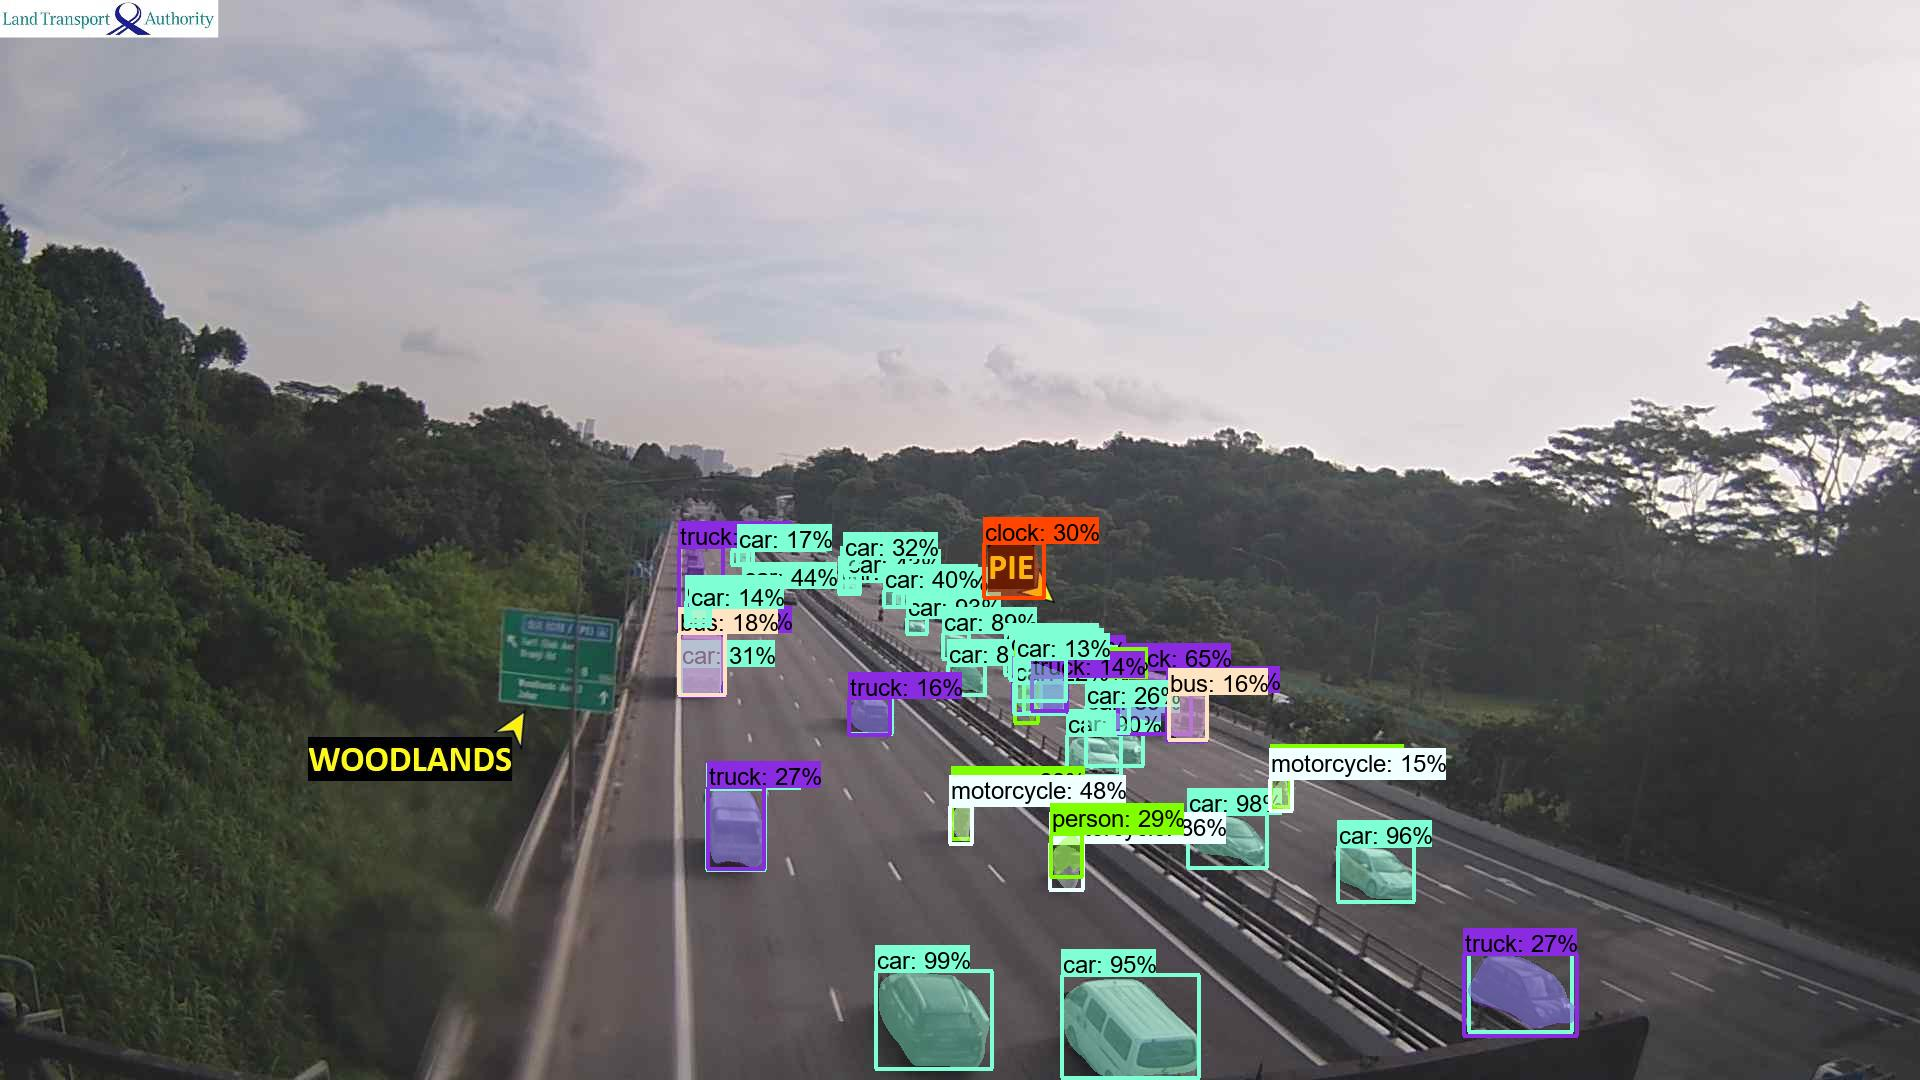

In [41]:
max_boxes_to_draw = 50   #@param {type:"integer"}
min_score_thresh = 0.1    #@param {type:"slider", min:0, max:1, step:0.01}

image_with_detections = visualization_utils.visualize_boxes_and_labels_on_image_array(
    np_image,
    detection_boxes,
    detection_classes,
    detection_scores,
    category_index,
    instance_masks=segmentations,
    use_normalized_coordinates=False,
    max_boxes_to_draw=max_boxes_to_draw,
    min_score_thresh=min_score_thresh)
output_image_path = 'test_results.jpg'
Image.fromarray(image_with_detections.astype(np.uint8)).save(output_image_path)
display.display(display.Image(output_image_path, width=1024))

In [42]:
print(detection_classes)

[ 3  3  3  3  3  3  3  3  3  3  3  4  3  3  8  3  8  1  1  8  3  8  3  4  3  3  3  3  3  3  3  3 85  1  8  8  3  8  3  1  3  6  3  3  8  6  4  8  3  3  3  3  7  8  3  6  8  8  3  8  3 10  3  3  3  8  3  3  3  3  8  8  8  9  3  3  3 11  3]


In [54]:
import pandas as pd
from collections import Counter

def benchmark_summary_mask_rcnn(results, data_source, data_time): 

    benchmark_results_mask_rcnn = pd.DataFrame(columns=['URL',
                                                   'TIME_SG',
                                                   'DETECTION_TIME',
                                                   'CAR_COUNT', 
                                                   'CAR_AVG_CONF',
                                                   'CAR_BOXES',
                                                   'MOTOR_CYCLE_COUNT',
                                                   'MC_AVG_CONF',
                                                   'MC_BOXES',
                                                   'BUS_COUNT',
                                                   'BUS_AVG_CONF',
                                                   'BUS_BOXES'
                                                   'MC_BOXES',
                                                   'TRUCK_COUNT',
                                                   'TRUCK_AVG_CONF',
                                                   'TRUCK_BOXES']
                                                    )


    # Reset counts and confidence counts
    car_count = 0
    car_conf_sum = 0
    car_boxes = []
    motor_cycle_count = 0
    motor_cycle_conf_sum = 0
    mc_boxes = []
    bus_count = 0
    bus_conf_sum = 0
    bus_boxes = []
    truck_count = 0
    truck_conf_sum = 0                                                                             
    truck_boxes = []

    for i, result in enumerate(results):
        
        obj_counter = Counter(result['detection_classes'])
        car_count = obj_counter[3]
        truck_count = obj_counter[8]
        motor_cycle_count = obj_counter[4]
        bus_count = obj_counter[6]

        for j, obj in enumerate(result['detection_classes']):
            # Car
            if obj == 3:
                car_conf_sum += result['detection_scores'][j] 
                car_boxes.append(result['detection_boxes'][j]) 
           
            # Motorcycle
            if obj == 4:
                motor_cycle_conf_sum += result['detection_scores'][j] 
                mc_boxes.append(result['detection_boxes'][j]) 
           
            # Truck
            if obj == 8:
                truck_conf_sum += result['detection_scores'][j] 
                truck_boxes.append(result['detection_boxes'][j]) 
           
            # Bus
            if obj == 6:
                bus_conf_sum += result['detection_scores'][j] 
                bus_boxes.append(result['detection_boxes'][j]) 
           
    

        # Evaluate average confidence for the different classes
        
        car_AVG_conf = car_conf_sum / car_count if car_count != 0 else 'N/A'

        bus_AVG_conf = bus_conf_sum / bus_count if bus_count != 0 else 'N/A'

        truck_AVG_conf = truck_conf_sum / truck_count if truck_count != 0 else 'N/A'

        MC_AVG_conf = motor_cycle_conf_sum / motor_cycle_count if motor_cycle_count != 0 else 'N/A'


        row = pd.DataFrame({'URL': [data_source[i]],
                            'TIME_SG':[data_time[i]],
                            'DETECTION_TIME': [result['detection_time']],
                            'CAR_COUNT': [car_count],
                            'CAR_AVG_CONF': [car_AVG_conf],
                            'CAR_BOXES': [car_boxes], 
                            'MOTOR_CYCLE_COUNT': [motor_cycle_count],
                            'MC_AVG_CONF': [MC_AVG_conf],
                            'MC_BOXES': [mc_boxes], 
                            'BUS_COUNT': [bus_count],
                            'BUS_AVG_CONF': [bus_AVG_conf],
                            'BUS_BOXES': [bus_boxes], 
                            'TRUCK_COUNT': [truck_count],
                            'TRUCK_AVG_CONF': [truck_AVG_conf],
                            'TRUCK_BOXES': [bus_boxes]
                            })


        benchmark_results_mask_rcnn = pd.concat([benchmark_results_mask_rcnn, row], ignore_index=True)

    return benchmark_results_mask_rcnn

In [44]:
import iUROP_custom
rcnn_results = iUROP_custom.detect_object_using_mask_rcnn('c6431e1d-fe35-4b97-a2e3-60e47e7ba921.jpg')


In [55]:

res = benchmark_summary_mask_rcnn([rcnn_results],[["N/A"]],[["N/A"]])

res.head()


C:\Users\f-bon\AppData\Local\Temp\ipykernel_20500\931439865.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  benchmark_results_mask_rcnn = pd.concat([benchmark_results_mask_rcnn, row], ignore_index=True)


,URL,TIME_SG,DETECTION_TIME,CAR_COUNT,CAR_AVG_CONF,CAR_BOXES,MOTOR_CYCLE_COUNT,MC_AVG_CONF,MC_BOXES,BUS_COUNT,BUS_AVG_CONF,BUS_BOXESMC_BOXES,TRUCK_COUNT,TRUCK_AVG_CONF,TRUCK_BOXES,BUS_BOXES
0,[N/A],[N/A],721.495,47,0.416282,"[[971.58685, 875.5287, 1068.7855, 992.24365], ...",3,0.501045,"[[843.3573, 1049.864, 889.5533, 1083.2145], [8...",3,0.151976,NaN,17,0.262651,"[[633.04034, 678.9105, 694.4673, 725.3563], [6...","[[633.04034, 678.9105, 694.4673, 725.3563], [6..."


In [46]:
#print(rcnn_results['detection_classes'])




# Count occurrences of each value
counter = Counter(rcnn_results['detection_classes'])

# Print the result
print(counter)
counter[3]

Counter({3: 47, 8: 17, 1: 4, 4: 3, 6: 3, 85: 1, 7: 1, 10: 1, 9: 1, 11: 1})


47